<a href="https://colab.research.google.com/github/P4ttyCakes/SegmentAl/blob/main/DeepV3_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os

In [2]:

def add_padding(image, target_size=(520, 520)):
    """Adds equal padding on both sides to make the image square while maintaining aspect ratio."""
    w, h = image.size
    max_dim = max(w, h)

    # Calculate padding to make the image square
    left = (max_dim - w) // 2
    top = (max_dim - h) // 2
    right = max_dim - w - left
    bottom = max_dim - h - top

    padding = (left, top, right, bottom)
    return ImageOps.expand(image, padding, fill=(0, 0, 0)), padding

In [3]:

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    padded_image, padding = add_padding(image)

    transform = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(padded_image).unsqueeze(0), padding, image

In [4]:

def remove_padding(segmentation_mask, original_size, padding):
    """Removes padding from the segmentation mask and resizes to match original image."""
    h, w = segmentation_mask.shape

    # Calculate the actual padding in the resized mask
    left = int(padding[0] * w / max(original_size))
    top = int(padding[1] * h / max(original_size))
    right = w - int(padding[2] * w / max(original_size))
    bottom = h - int(padding[3] * h / max(original_size))

    return segmentation_mask[top:bottom, left:right]

In [5]:

def visualize_segmentation(image_path, model):
    input_tensor, padding, original_image = preprocess_image(image_path)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]

    output_predictions = output.argmax(0).byte().cpu().numpy()

    # Remove padding while maintaining aspect ratio
    output_predictions = remove_padding(output_predictions, original_image.size, padding)

    # Resize mask to match original image size
    mask_pil = Image.fromarray(output_predictions)
    mask_pil = mask_pil.resize(original_image.size, Image.NEAREST)
    output_predictions = np.array(mask_pil)

    # Convert original image to numpy array
    original_np = np.array(original_image)

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(original_np)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Create a custom colormap for the segmentation mask
    segmentation_colors = plt.cm.jet(np.linspace(0, 1, 21))
    colored_mask = segmentation_colors[output_predictions]

    # Overlay the mask on the original image
    ax[1].imshow(original_np)
    ax[1].imshow(colored_mask[..., :3], alpha=0.5)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:

def show_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_np = tensor.squeeze(0).cpu()
    image_np = image_np * std + mean
    image_np = image_np.permute(1, 2, 0).numpy()
    image_np = np.clip(image_np, 0, 1)

    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

Using cache found in /Users/patricklu/.cache/torch/hub/pytorch_vision_v0.10.0


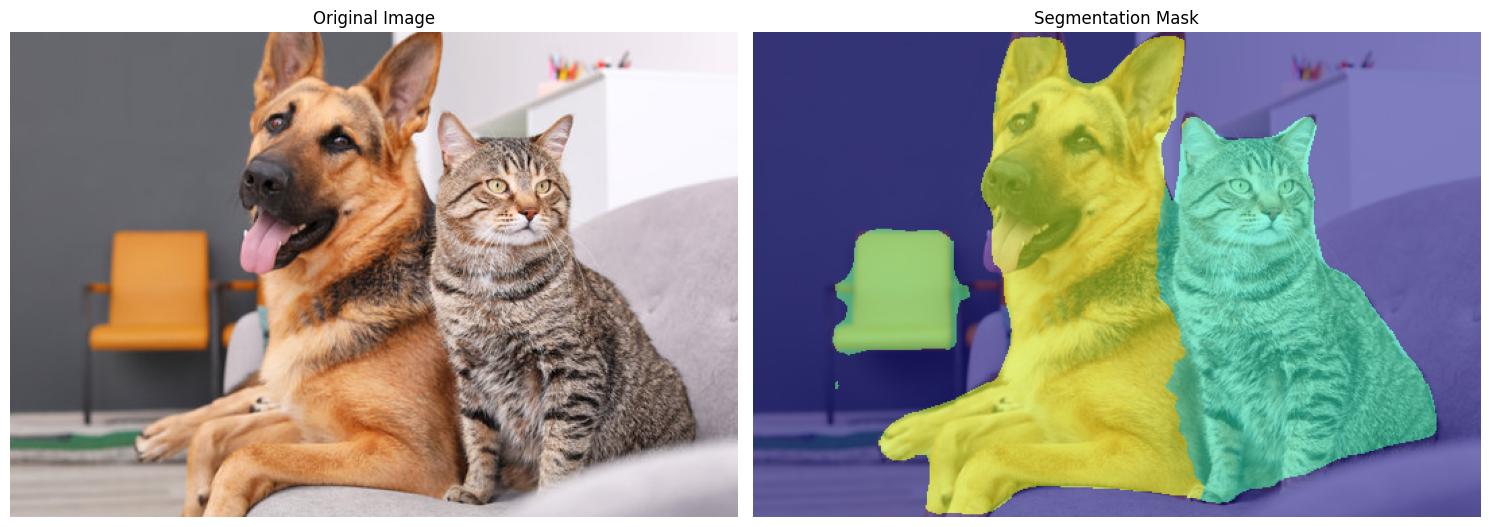

In [10]:

# Load model
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

# Manually set image path
image_path = "/Users/patricklu/Downloads/cat and dog.jpg"

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at {image_path}. Please check the path.")

torch.set_grad_enabled(False)
visualize_segmentation(image_path, model)
